# Run exathlon pipeline

From the `src` directory, run with the default pipeline parameters:

```bash
> python run_pipeline.py --pipeline-type ad --app-id 0 --model-type ae --scoring-method mse
> python run_pipeline.py --pipeline-type ad --app-id 0 --model-type ts2vec --scoring-method knn
```

Then, run the following section of the notebook.

## Setup and Pipeline Parameters

In [39]:
%matplotlib inline

# enable imports directly from the src directory
import os
import sys
sys.path.append(os.path.join(os.pardir, 'src'))

In [40]:
import argparse

ARGS = {
    # data-specific arguments
    'data': 'spark',
    'app_id': 0,
    'trace_types': '.',
    'ignored_anomalies': 'none',
    
    # datasets constitution arguments
    'n_starting_removed': 0,
    'n_ending_removed': 0,
    # optional downsampling to perform on both data and labels to save storage
    'pre_sampling_period': '15s',

    # features alteration and transformation arguments
    'alter_bundles': 'spark_bundles',
    'alter_bundle_idx': 0,
    # final sampling period to use for data records
    'data_sampling_period': '15s',
    'data_downsampling_position': 'last',
    # final sampling period to use for labels
    'labels_sampling_period': '15s',
    'transform_chain': 'trace_scaling',
    # if a transformation step is repeated, the same arguments are used for all its instances
    'head_size': 240,
    'online_window_type': 'expanding',
    # if not -1, weight of a regular pretraining of the scaler in
    # the convex combination with its head/head-online training
    'regular_pretraining_weight': -1,
    'scaling_method': 'std',
    # only relevant for "regular" scaling
    'reg_scaler_training': 'all.training',
    'minmax_range': [0, 1],
    'pca_n_components': 13,
    'pca_kernel': 'linear',
    'pca_training': 'all.training',
    'fa_n_components': 13,
    'fa_training': 'all.training',

    # normality modeling arguments
    'modeling_n_periods': -1,
    'modeling_data_prop': 1.0,
    'modeling_data_seed': 0,
    'modeling_split': 'stratified.split',
    'modeling_split_seed': 21,
    'n_period_strata': 3,
    'modeling_val_prop': 0.15,
    'modeling_test_prop': 0.15,
    'model_type': 'ts2vec',




    # FORECASTING MODELS #
    'n_back': 40,
    'n_forward': 1,
    # RNN
    'rnn_unit_type': 'lstm',
    'rnn_n_hidden_neurons': [144, 40],
    'rnn_dropout': 0.0,
    'rnn_rec_dropout': 0.0,
    'rnn_optimizer': 'adam',
    'rnn_learning_rate': 7.869 * (10 ** -4),
    'rnn_n_epochs': 200,
    'rnn_batch_size': 32,
    # RECONSTRUCTION MODELS #
    'window_size': 40,
    'window_step': 1,
    # autoencoder
    'ae_latent_dim': 32,
    'ae_type': 'dense',
    'ae_enc_n_hidden_neurons': [200],
    'ae_dec_last_activation': 'linear',
    'ae_dropout': 0.0,
    'ae_dense_layers_activation': 'relu',
    'ae_rec_unit_type': 'lstm',
    'ae_rec_dropout': 0.0,
    'ae_loss': 'mse',
    'ae_optimizer': 'adam',
    'ae_learning_rate': 3.602 * (10 ** -4),
    'ae_n_epochs': 200,
    'ae_batch_size': 32,
    # BiGAN
    'bigan_latent_dim': 32,
    'bigan_enc_type': 'rec',
    'bigan_enc_arch_idx': -1,
    'bigan_enc_rec_n_hidden_neurons': [100],
    'bigan_enc_rec_unit_type': 'lstm',
    'bigan_enc_conv_n_filters': 32,
    'bigan_enc_dropout': 0.0,
    'bigan_enc_rec_dropout': 0.0,
    'bigan_gen_type': 'rec',
    'bigan_gen_last_activation': 'linear',
    'bigan_gen_arch_idx': -1,
    'bigan_gen_rec_n_hidden_neurons': [100],
    'bigan_gen_rec_unit_type': 'lstm',
    'bigan_gen_conv_n_filters': 64,
    'bigan_gen_dropout': 0.0,
    'bigan_gen_rec_dropout': 0.0,
    'bigan_dis_type': 'conv',
    'bigan_dis_arch_idx': 0,
    'bigan_dis_x_rec_n_hidden_neurons': [30, 10],
    'bigan_dis_x_rec_unit_type': 'lstm',
    'bigan_dis_x_conv_n_filters': 32,
    'bigan_dis_x_dropout': 0.0,
    'bigan_dis_x_rec_dropout': 0.0,
    'bigan_dis_z_n_hidden_neurons': [32, 10],
    'bigan_dis_z_dropout': 0.0,
    'bigan_dis_threshold': 0.0,
    'bigan_dis_optimizer': 'adam',
    'bigan_enc_gen_optimizer': 'adam',
    'bigan_dis_learning_rate': 0.0004,
    'bigan_enc_gen_learning_rate': 0.0001,
    'bigan_n_epochs': 200,
    'bigan_batch_size': 32,
    # TS2Vec
    'ts2vec_input_dims': 19,
    'ts2vec_output_dims': 320,
    'ts2vec_hidden_dims': 64,
    'ts2vec_depth': 10,
    'ts2vec_device': 'cpu',
    'ts2vec_lr': 0.001,
    'ts2vec_batch_size': 16,
    'ts2vec_max_train_length': None,
    'ts2vec_temporal_unit': 0,
    'ts2vec_after_iter_callback': None,
    'ts2vec_after_epoch_callback': None,
    'ts2vec_n_epochs': 100,
    'ts2vec_n_iters': None,
    'ts2vec_verbose': True,


    # outlier score assignment arguments
    'scoring_method': 'knn',

    # supervised evaluation for assessing scoring performance
    'evaluation_type': 'ad2',
    'recall_alpha': 0.0,
    'recall_omega': 'default',
    'recall_delta': 'flat',
    'recall_gamma': 'dup',
    'precision_omega': 'default',
    'precision_delta': 'flat',
    'precision_gamma': 'dup',
    'f_score_beta': 1.0,

    # outlier score threshold selection arguments
    'thresholding_method': ['std', 'mad', 'iqr'],
    'thresholding_factor': [1.5, 2.0, 2.5, 3.0],
    'n_iterations': [1, 2],
    'removal_factor': [1.0],

    # explanation discovery arguments
    'explanation_method': 'exstream',
    'explained_predictions': 'ground.truth',
    # ED evaluation parameters
    'ed_eval_min_anomaly_length': 1,
    'ed1_consistency_n_disturbances': 5,
    # model-free evaluation
    'mf_eval_min_normal_length': 1,
    'mf_ed1_consistency_sampled_prop': 0.8,
    'mf_ed1_accuracy_n_splits': 5,
    'mf_ed1_accuracy_test_prop': 0.2,
    # model-dependent evaluation
    'md_eval_small_anomalies_expansion': 'before',
    'md_eval_large_anomalies_coverage': 'all',
    # EXstream
    'exstream_fp_scaled_std_threshold': 1.64,
    # MacroBase
    'macrobase_n_bins': 10,
    'macrobase_min_support': 0.4,
    'macrobase_min_risk_ratio': 1.5,
    # LIME
    'lime_n_features': 5,

    # pipeline execution shortcut arguments
    'pipeline_type': 'ad'
}
args = argparse.Namespace(**ARGS)

## Figure 4(a) - Trace-wise Separation for T2 Trace of Application 2

In [41]:
import importlib

from utils.common import PIPELINE_TEST_NAME, get_output_path, get_modeling_task_and_classes
from data.helpers import load_datasets_data

# set input and output paths
DATA_INFO_PATH = get_output_path(args, 'make_datasets')
DATA_INPUT_PATH = get_output_path(args, 'build_features', 'data')
MODEL_INPUT_PATH = get_output_path(args, 'train_model')
OUTPUT_PATH = get_output_path(args, 'train_detector', 'model')

# load test data
data = load_datasets_data(DATA_INPUT_PATH, DATA_INFO_PATH, [PIPELINE_TEST_NAME])

# initialize relevant scorer based on command-line arguments
task_type, model_classes = get_modeling_task_and_classes(args)
a_t = 'the type of task must be either `forecasting` or `reconstruction`'
assert task_type in ['forecasting', 'reconstruction', 'embedding'], a_t
scoring_classes = importlib.import_module(f'scoring.{task_type}.{task_type}_scorers').scoring_classes
if args.model_type == 'naive.forecasting':
    model = model_classes[args.model_type](args, '')
else:
    model = model_classes[args.model_type].from_file(args, MODEL_INPUT_PATH)
scorer = scoring_classes[args.scoring_method](args, model, OUTPUT_PATH)

loading numpy files from /home/markus/Desktop/master_thesis/pipeline/thesis_AD_pipeline/exathlon/outputs/data/processed/spark_0_15s/spark_0_trace-scl_std
loading `test.npy`... done.
loading numpy files from /home/markus/Desktop/master_thesis/pipeline/thesis_AD_pipeline/exathlon/outputs/data/processed/spark_0_15s/spark_0_trace-scl_std
loading `y_test.npy`... done.
loading pickle files from /home/markus/Desktop/master_thesis/pipeline/thesis_AD_pipeline/exathlon/outputs/data/interim/spark_0_15s
loading `test_info.pkl`... done.
loading embedding model file /home/markus/Desktop/master_thesis/pipeline/thesis_AD_pipeline/exathlon/outputs/models/spark_0_15s/spark_0_trace-scl_std/stratified_21_3_0.15_0.15/ts2vec/model.pt... done.


In [42]:
import numpy as np

# derive outlier scores for T2 trace of application 2
trace_name = '2_2_200000_69'

trace_idx = [i for i, t in enumerate(data['test_info']) if t[0] == trace_name][0]
trace_data, trace_labels = np.array([data['test'][trace_idx]]), np.array([data['y_test'][trace_idx]])
trace_scores = scorer.score(trace_data)

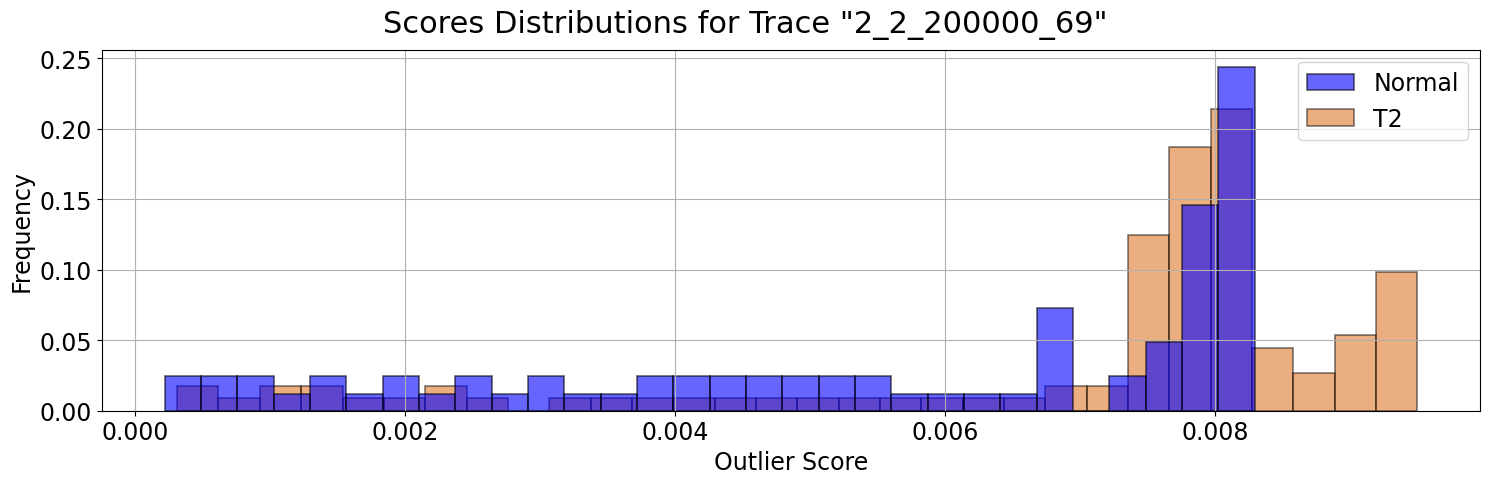

In [43]:
from utils.spark import ANOMALY_TYPES
from visualization.periods.array import plot_scores_distributions
from visualization.helpers.spark import METRICS_COLORS
    
# plot outlier scores distribution
plot_scores_distributions(
    trace_scores, trace_labels,
    fig_title=f'Scores Distributions for Trace "{trace_name}"',
    type_colors=METRICS_COLORS,
    anomaly_types=ANOMALY_TYPES
)

## Figure 4(d) - Outlier Scores of Modeling Test Samples with "Best" Threshold

In [44]:
import pickle

from utils.common import PIPELINE_TRAIN_NAME, MODELING_TEST_NAME, get_best_thresholding_args
from data.helpers import load_mixed_formats
from modeling.data_splitters import get_splitter_classes
from modeling.forecasting.helpers import get_trimmed_periods

# load test samples of the modeling set
if task_type == 'forecasting':
    data[f'y_{PIPELINE_TEST_NAME}'] = get_trimmed_periods(data[f'y_{PIPELINE_TEST_NAME}'], args.n_back)
    kwargs = {'n_back': args.n_back, 'n_forward': args.n_forward}
else:
    kwargs = {'window_size': args.window_size, 'window_step': args.window_step}

print('loading training periods and information...', end=' ', flush=True)
modeling_files = load_mixed_formats(
    [DATA_INPUT_PATH, DATA_INFO_PATH],
    [PIPELINE_TRAIN_NAME, f'{PIPELINE_TRAIN_NAME}_info'],
    ['numpy', 'pickle']
)
print('done.')
print('recovering modeling test samples...', end=' ', flush=True)
data_splitter = get_splitter_classes()[args.modeling_split](args)
data = data_splitter.get_modeling_split(
    modeling_files[PIPELINE_TRAIN_NAME], modeling_files[f'{PIPELINE_TRAIN_NAME}_info'], **kwargs
)
modeling_test_data = {
    k.replace(f'_{MODELING_TEST_NAME}', ''): v for k, v in data.items() if MODELING_TEST_NAME in k
}
print('done.')

# load "best" outlier score threshold value
best_threshold = pickle.load(open(
    os.path.join(get_output_path(get_best_thresholding_args(args), 'train_detector'), 'threshold.pkl'), 'rb'
))

loading training periods and information... loading numpy files from /home/markus/Desktop/master_thesis/pipeline/thesis_AD_pipeline/exathlon/outputs/data/processed/spark_0_15s/spark_0_trace-scl_std
loading `train.npy`... done.
loading pickle files from /home/markus/Desktop/master_thesis/pipeline/thesis_AD_pipeline/exathlon/outputs/data/interim/spark_0_15s
loading `train_info.pkl`... done.
done.
recovering modeling test samples... setting samples creation function for the ts2vec model... done.
dividing every period into 3 equal bins... done.
sampling, shuffling and adding each bin to the datasets... done.
done.


In [45]:
# format modeling test samples according to the type of method
if 'y' in modeling_test_data:
    if len(modeling_test_data['y'].shape) == 2:
        n_samples, n_features = modeling_test_data['y'].shape
        modeling_test_data['y'] = modeling_test_data['y'].reshape((n_samples, 1, n_features))
    modeling_test_samples = np.array([
        np.concatenate([X, y]) for X, y in zip(modeling_test_data['X'], modeling_test_data['y'])
    ])
else:
    modeling_test_samples = modeling_test_data['X']
                    
# derive modeling test outlier scores
modeling_test_scores = scorer.score_windows(modeling_test_samples)

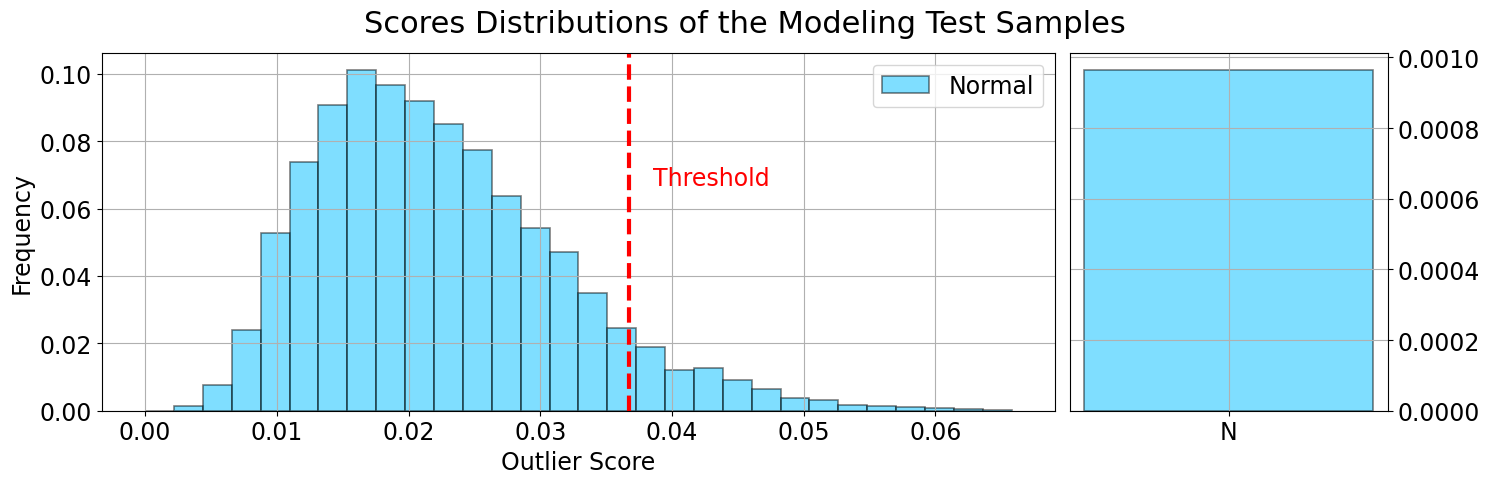

In [46]:
# plot outlier scores distribution of modeling test samples, with highlighted "best" threshold value
metrics_colors = METRICS_COLORS.copy()
metrics_colors['normal'] = 'deepskyblue'

plot_scores_distributions(
    np.array([np.array(modeling_test_scores)]), np.array([np.zeros(shape=(len(modeling_test_scores),))]),
    fig_title=f'Scores Distributions of the Modeling Test Samples',
    threshold=best_threshold,
    type_colors=metrics_colors,
    anomaly_types=ANOMALY_TYPES
)